## Exercise 01
#### Agajan Torayev
<a src="https://github.com/torayeff/NLPLab">Github: @torayeff</a>

In [5]:
import nltk
import pickle
import numpy as np
import itertools

### Helper Functions

In [6]:
def features(sentence, index):
    """Form a feature dictionary for word.
    
    Args:
        sentence: Sentence as a list of words.
        index: The position of word in sentence as integer.
    
    Returns:
        Dictionary of features for the word in sentence
    """
    
    return {
        'word': sentence[index],
        'is_capitalized': sentence[index][0].upper() == (sentence[index][0] and sentence[index][0].isalpha()),
        'prefix-1': sentence[index][0],
        'prefix-2': '' if len(sentence[index]) < 2 else sentence[index][:2],
        'suffix-1': sentence[index][-1],
        'suffix-2': '' if len(sentence[index]) < 2 else sentence[index][-2:],
        'prev_word-1': '' if index == 0 else sentence[index - 1],
        'prev_word-2': '' if index <= 1 else sentence[index - 2],
        'next_word-1': '' if index == len(sentence) - 1 else sentence[index + 1],
        'next_word-2': '' if index >= len(sentence) - 2 else sentence[index + 2],
    }


def untag(tagged_sentence):
    """Untag the tagged sentence.
    
    Args: 
        tagged_sentence: The tagged sentence as list of tuples.
    
    Returns:
        List of words of sentence without tags.
    """
    
    return [word for word, tag in tagged_sentence]


def transform_to_dataset(tagged_sentences):
    """Form a dataset from the given tagged sentences.
    
    Args:
        tagged_sentences: List of list of tuples of tagged sentences.
    
    Return:
        List of dictionaries as features X.
        List of strings representing tag.
    """
    
    X, y = [], []
    for tagged_sent in tagged_sentences:
        untagged_sent = untag(tagged_sent)
        for index in range(len(untagged_sent)):
            X.append(features(untagged_sent, index))
            y.append(tagged_sent[index][1])
            
    return X, y

## Model 1
### Own POS Tagger (English)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

def pos_model(corpus, corpus_name, load=False, save=True, cutoff_ratio=0.8, size=10000):
    """Train POS model.
    
    Args:
        corpus: List of tagged sents.
        corpus_name: Name of corpus as string.
        load: Boolean, load model from file corpus_name. Default False.
        save: Boolean, save model to file corpus_name. Default True.
        cutoff_ratio: Ratio for splitting into training and test setences. Default 0.8.
        size: Size for training set. Default 10000.
        
    Returns:
        model: Trained POS model.
        score: The accuracy of model on given corpus.
    """
    
    cutoff = int(cutoff_ratio * len(corpus))

    training_sentences = corpus[:cutoff]
    test_sentences = corpus[cutoff:]
    
    X, y = transform_to_dataset(training_sentences)
    X_test, y_test = transform_to_dataset(test_sentences)
    
    if load:
        print("[Loading the model.]")
        with open(corpus_name, "rb") as model_file:
            model = pickle.load(model_file)
    else:
        print("[Training the model.]")
        
        model = Pipeline([
            ('vectorizer', DictVectorizer(sparse=False)),
            ('classifier', DecisionTreeClassifier(criterion='entropy'))
        ])
        
        model.fit(X[:size], y[:size])
    
        if save:
            print("[Saving the model to file.]")
            with open(corpus_name, "wb") as model_file:
                pickle.dump(model, model_file)
    
    score = model.score(X_test, y_test)
    print("[Accuracy of model: %lf]"% (score))
    
    return model, score

#### Penn TreeBank Corpus

In [8]:
model, performance_1_1 = pos_model(nltk.corpus.treebank.tagged_sents(), "penntreebank", load=True, size=10000)

[Loading the model.]
[Accuracy of model: 0.871600]


#### Brown Corpus

In [9]:
model, performance_1_4 = pos_model(nltk.corpus.brown.tagged_sents(), "browncorpus", load=True, size=10000)

[Loading the model.]
[Accuracy of model: 0.755467]


## Model 2
### Pre-trained NLTK POS tagger

In [10]:
def model2(corpus_sents, corpus_tagged):
    """Test pre-trained NLTK POS tagger.
    
    Args:
        corpus_sents: List of corpus sentences.
        corpus_tagged: List of lists of tuples of tagged sentences in the corpus.
        
    Returns:
        Accuracy of the pre-trained POS tagger on the given corpus.
    """
    
    cutoff = int(0.8 * len(corpus_sents))
    test_sentences = corpus_sents[cutoff:]

    gold_standard = corpus_tagged[cutoff:]
    y_pred = [nltk.pos_tag(sent) for sent in test_sentences]

    a = [t[1] for t in list(itertools.chain(*y_pred))]
    b = [t[1] for t in list(itertools.chain(*gold_standard))]

    return np.mean(np.array(a) == np.array(b))

#### Penn TreeBank Corpus

In [11]:
performance_1_2 = model2(nltk.corpus.treebank.sents(), nltk.corpus.treebank.tagged_sents()) 
print(performance_1_2)

0.8937072708218973


#### Brown Corpus

In [12]:
performance_1_5 = model2(nltk.corpus.brown.sents(), nltk.corpus.brown.tagged_sents()) 
print(performance_1_5)

0.6062210128562457


## Model 3
### Rule based classifiers

In [13]:
from nltk import DefaultTagger as df
from nltk import UnigramTagger as ut
from nltk import BigramTagger as bt
from nltk import TrigramTagger as tg

patterns = [(r'.*ing$', 'VBG'), (r'.*ed$', 'VBD'),
                (r'.*es$', 'VBZ'), (r'.*ould$', 'MD'),
                (r'.*\'s$', 'NN$'), (r'.*s$', 'NNS'),
                (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), (r'.*', 'NN')]

#### Penn Treebank Corpus

In [14]:
tagged_sents = nltk.corpus.treebank.tagged_sents()
cutoff = int(len(tagged_sents) * 0.8)
train_sents = tagged_sents[:cutoff]
test_sents = tagged_sents[cutoff:]

# Default Tagger
performance_1_3_1 = nltk.DefaultTagger('NN').evaluate(test_sents)
print("[Default Tagger accuracy on Treebank Corpus: %lf]"%performance_1_3_1)

# Unigram Tagger
performance_1_3_2 = nltk.UnigramTagger(train_sents).evaluate(test_sents)
print("[Unigram Tagger accuracy on Treebank Corpus: %lf]"%performance_1_3_2)

# Bigram Tagger
performance_1_3_3 = nltk.BigramTagger(train_sents).evaluate(test_sents)
print("[Bigram Tagger accuracy on Treebank Corpus: %lf]"%performance_1_3_3)

# Trigram Tagger
performance_1_3_4 = nltk.TrigramTagger(train_sents).evaluate(test_sents)
print("[Trigram Tagger accuracy on Treebank Corpus: %lf]"%performance_1_3_4)

# Regexp Tagger
performance_1_3_5 = nltk.RegexpTagger(patterns).evaluate(test_sents)
print("[Regexp Tagger accuracy on Treebank Corpus: %lf]"%performance_1_3_5)

[Default Tagger accuracy on Treebank Corpus: 0.144768]
[Unigram Tagger accuracy on Treebank Corpus: 0.860821]
[Bigram Tagger accuracy on Treebank Corpus: 0.113279]
[Trigram Tagger accuracy on Treebank Corpus: 0.067369]
[Regexp Tagger accuracy on Treebank Corpus: 0.242327]


In [15]:
#### Brown Corpus
tagged_sents = nltk.corpus.brown.tagged_sents()
cutoff = int(len(tagged_sents) * 0.8)
train_sents = tagged_sents[:cutoff]
test_sents = tagged_sents[cutoff:]

# Default Tagger
performance_1_6_1 = nltk.DefaultTagger('NN').evaluate(test_sents)
print("[Default Tagger accuracy on Brown Corpus: %lf]"%performance_1_6_1)

# Unigram Tagger
performance_1_6_2 = nltk.UnigramTagger(train_sents).evaluate(test_sents)
print("[Unigram Tagger accuracy on Brown Corpus: %lf]"%performance_1_6_2)

# Bigram Tagger
performance_1_6_3 = nltk.BigramTagger(train_sents).evaluate(test_sents)
print("[Bigram Tagger accuracy on Brown Corpus: %lf]"%performance_1_6_3)

# Trigram Tagger
performance_1_6_4 = nltk.TrigramTagger(train_sents).evaluate(test_sents)
print("[Trigram Tagger accuracy on Brown Corpus: %lf]"%performance_1_6_4)

# Regexp Tagger
performance_1_6_5 = nltk.RegexpTagger(patterns).evaluate(test_sents)
print("[Regexp Tagger accuracy on Brown Corpus: %lf]"%performance_1_6_5)

[Default Tagger accuracy on Brown Corpus: 0.109978]
[Unigram Tagger accuracy on Brown Corpus: 0.877375]
[Bigram Tagger accuracy on Brown Corpus: 0.339049]
[Trigram Tagger accuracy on Brown Corpus: 0.191786]
[Regexp Tagger accuracy on Brown Corpus: 0.175944]


## Model 4
### Own POS Tagger (Spanish)

In [16]:
spanish_corpus = nltk.corpus.ConllCorpusReader('.', 'IULA_Spanish_LSP_Treebank.conll',
                                              ('ignore', 'words', 'ignore', 'ignore', 
                                               'pos', 'ignore', 'ignore'))

In [17]:
model, performance_2_1 = pos_model(spanish_corpus.tagged_sents(), "spanish_model", load=True)

[Loading the model.]
[Accuracy of model: 0.723065]


## Model 5

### Pre-trained POS tagger model using TreeTagger (Spanish)

In [18]:
import os
os.environ['TREETAGGER_HOME'] = "/Users/torayeff/treetagger/cmd"
from treetagger import TreeTagger
tt = TreeTagger(language='spanish')
size = 1000

In [19]:
with open("spanish_pre_trained", "rb") as handle:
    pred_tags = pickle.load(handle)

In [20]:
# pred_tags = []
# for sent in spanish_corpus.sents()[:size]:
#     y = tt.tag(sent)
#     for pos in y:
#         pred_tags.append(pos[1])
# with open("spanish_pre_trained", "wb") as handle:
#     pickle.dump(pred_tags, handle)

In [21]:
b = [t[1] for t in list(itertools.chain(*spanish_corpus.tagged_sents()[:size]))]
mc = min(len(b), len(pred_tags))
performance_2_2 = np.mean(np.array(pred_tags[:mc]) == np.array(b[:mc]))
print(performance_2_2)
print("[!!!The accuracy is low due to different tagsets of treetagger and corpus being tested!!!]")

0.0027618859735648055
[!!!The accuracy is low due to different tagsets of treetagger and corpus being tested!!!]


## Charts

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

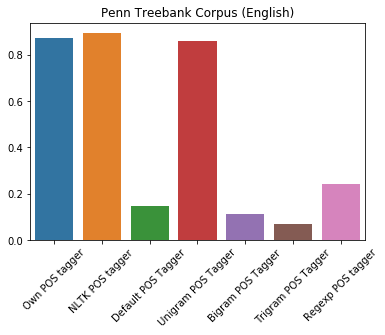

In [45]:
x = ['Own POS tagger','NLTK POS tagger','Default POS Tagger', 
                  'Unigram POS Tagger', 'Bigram POS Tagger', 'Trigram POS Tagger', 'Regexp POS tagger']
y = [performance_1_1, performance_1_2, performance_1_3_1, performance_1_3_2,
                    performance_1_3_3, performance_1_3_4, performance_1_3_5]
sns.barplot(x, y)
plt.title('Penn Treebank Corpus (English)')
plt.xticks(rotation=45)

In [39]:
x = ['Own POS tagger','NLTK POS tagger','Default POS Tagger', 
                  'Unigram POS Tagger', 'Bigram POS Tagger', 'Trigram POS Tagger', 'Regexp POS tagger'],

y = [performance_1_4, performance_1_5, performance_1_6_1, performance_1_6_2,
               performance_1_6_3, performance_1_6_4, performance_1_6_5]

layout = go.Layout(
    title='Brown Corpus (English))',
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='performance_1_brown')

In [40]:
data = [go.Bar(
            x=['Own POS tagger','Treetagger'],
            y=[performance_2_1, performance_2_2]
    )]

layout = go.Layout(
    title="Spanish Corpus (accuracy is low due  to tagsets mismatch!!!)",
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='performance_2_spanish')